<a href="https://colab.research.google.com/github/WilderGitHub/datascience/blob/main/proyectofinal_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import os
from IPython.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, transforms

import os, shutil, time

In [ ]:
%rm -rf checkpoints
%rm -rf imagenes
%rm -rf outputs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ruta="/content/drive/MyDrive/PerrosData"
#folders = os.listdir(ruta)
archivos=[]
#for folder in folders:
for file in os.listdir(ruta):
    archivos.append(file)

In [ ]:

archivos[0]
random.shuffle(archivos)
archivos[0]

'n02109525_9379.jpg'

In [ ]:
# a ver
import os
os.makedirs('imagenes/entrenamiento/class/', exist_ok=True)
os.makedirs('imagenes/validacion/class/', exist_ok=True)
for i, file in enumerate(os.listdir('perritos')):
  if i < 100:
    os.rename('perritos/' + file, 'imagenes/validacion/class/' + file)
  else:
    os.rename('perritos/' + file, 'imagenes/entrenamiento/class/' + file)

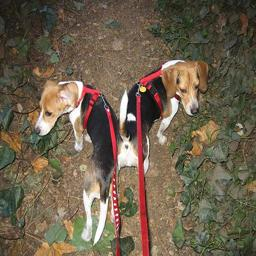

In [ ]:
display(Image(filename='imagenes/validacion/class/n02088364_11130.jpg'))

In [ ]:
# Download and import libraries
#####!pip install torch torchvision matplotlib numpy scikit-image pillow==4.1.1

In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    resnet = models.resnet18(num_classes=365)

    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))

    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])


    self.upsample = nn.Sequential(
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    midlevel_features = self.midlevel_resnet(input)

    output = self.upsample(midlevel_features)
    return output

In [ ]:
model = ColorizationNet()

In [ ]:
from torchsummary import summary
summary(model,input_size = (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

#### Cargamos datos

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):

  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [ ]:
# Entrenamiento
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('imagenes/entrenamiento', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validacion
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('imagenes/validacion' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [ ]:
class AverageMeter(object):

  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):

  plt.clf()
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy()
  color_image = color_image.transpose((1, 2, 0))
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None:
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

#### Validacion

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    output_ab = model(input_gray)
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))


    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)):
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    batch_time.update(time.time() - end)
    end = time.time()

    if i % 25 == 0:
      print('Validar: [{0}/{1}]\t'
            'Tiempo {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Validacion terminada')
  return losses.avg

#### Entrenamiento

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()


  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):


    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    data_time.update(time.time() - end)

    output_ab = model(input_gray)
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Tiempo {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses))

  print('Epoch {}'.format(epoch))

In [ ]:
if use_gpu:
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 20

In [ ]:
# Entrenamos Modelo
for epoch in range(epochs):

  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)

  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/8]	Tiempo 18.923 (18.923)	Data 1.727 (1.727)	Loss 0.3270 (0.3270)	
Epoch 0


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49712 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49716 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49708 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49704 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49700 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: Use

Validar: [0/2]	Tiempo 7.626 (7.626)	Loss 1003222.9375 (1003222.9375)	
Validacion terminada
Starting training epoch 1
Epoch: [1][0/8]	Tiempo 16.231 (16.231)	Data 1.624 (1.624)	Loss 0.0504 (0.0504)	
Epoch 1


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 39955 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 15871 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 47550 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 15145 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 36083 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: Use

Validar: [0/2]	Tiempo 6.296 (6.296)	Loss 246.2292 (246.2292)	
Validacion terminada
Starting training epoch 2
Epoch: [2][0/8]	Tiempo 16.036 (16.036)	Data 1.543 (1.543)	Loss 0.0234 (0.0234)	
Epoch 2


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5094 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 20667 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8731 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 12338 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8392 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWa

Validar: [0/2]	Tiempo 6.533 (6.533)	Loss 2.0625 (2.0625)	
Validacion terminada
Starting training epoch 3
Epoch: [3][0/8]	Tiempo 16.293 (16.293)	Data 1.536 (1.536)	Loss 0.0171 (0.0171)	
Epoch 3


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 940 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2012 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5252 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Co

Validar: [0/2]	Tiempo 6.568 (6.568)	Loss 0.1689 (0.1689)	
Validacion terminada
Starting training epoch 4
Epoch: [4][0/8]	Tiempo 17.387 (17.387)	Data 1.585 (1.585)	Loss 0.0133 (0.0133)	
Epoch 4


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 87 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 123 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3353 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1151 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validar: [0/2]	Tiempo 6.298 (6.298)	Loss 0.0358 (0.0358)	
Validacion terminada
Starting training epoch 5
Epoch: [5][0/8]	Tiempo 16.935 (16.935)	Data 1.570 (1.570)	Loss 0.0112 (0.0112)	
Epoch 5


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1043 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validar: [0/2]	Tiempo 6.254 (6.254)	Loss 0.0088 (0.0088)	
Validacion terminada
Starting training epoch 6
Epoch: [6][0/8]	Tiempo 16.012 (16.012)	Data 1.574 (1.574)	Loss 0.0081 (0.0081)	
Epoch 6


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validar: [0/2]	Tiempo 6.414 (6.414)	Loss 0.0058 (0.0058)	
Validacion terminada
Starting training epoch 7
Epoch: [7][0/8]	Tiempo 17.295 (17.295)	Data 1.550 (1.550)	Loss 0.0057 (0.0057)	
Epoch 7


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1352 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validar: [0/2]	Tiempo 6.535 (6.535)	Loss 0.0058 (0.0058)	
Validacion terminada
Starting training epoch 8
Epoch: [8][0/8]	Tiempo 16.377 (16.377)	Data 1.604 (1.604)	Loss 0.0046 (0.0046)	
Epoch 8


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1602 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validar: [0/2]	Tiempo 6.420 (6.420)	Loss 0.0064 (0.0064)	
Validacion terminada
Starting training epoch 9
Epoch: [9][0/8]	Tiempo 16.076 (16.076)	Data 1.618 (1.618)	Loss 0.0050 (0.0050)	
Epoch 9
Validar: [0/2]	Tiempo 6.442 (6.442)	Loss 0.0037 (0.0037)	
Validacion terminada
Starting training epoch 10
Epoch: [10][0/8]	Tiempo 16.689 (16.689)	Data 1.636 (1.636)	Loss 0.0030 (0.0030)	
Epoch 10
Validar: [0/2]	Tiempo 6.474 (6.474)	Loss 0.0044 (0.0044)	
Validacion terminada
Starting training epoch 11
Epoch: [11][0/8]	Tiempo 16.077 (16.077)	Data 1.583 (1.583)	Loss 0.0038 (0.0038)	
Epoch 11
Validar: [0/2]	Tiempo 6.348 (6.348)	Loss 0.0045 (0.0045)	
Validacion terminada
Starting training epoch 12
Epoch: [12][0/8]	Tiempo 15.847 (15.847)	Data 1.557 (1.557)	Loss 0.0027 (0.0027)	
Epoch 12
Validar: [0/2]	Tiempo 6.544 (6.544)	Loss 0.0050 (0.0050)	
Validacion terminada
Starting training epoch 13
Epoch: [13][0/8]	Tiempo 16.142 (16.142)	Data 1.503 (1.503)	Loss 0.0040 (0.0040)	
Epoch 13
Validar: [0/2]	Tiempo 6

/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validar: [0/2]	Tiempo 6.526 (6.526)	Loss 0.0030 (0.0030)	
Validacion terminada


<Figure size 432x288 with 0 Axes>

### Resultados

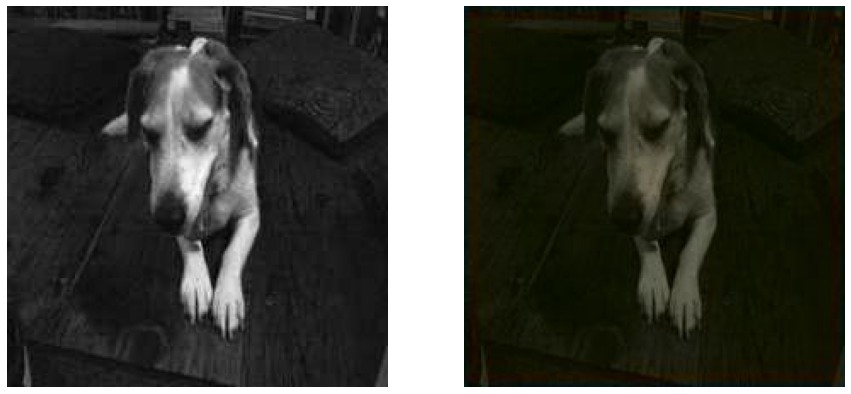

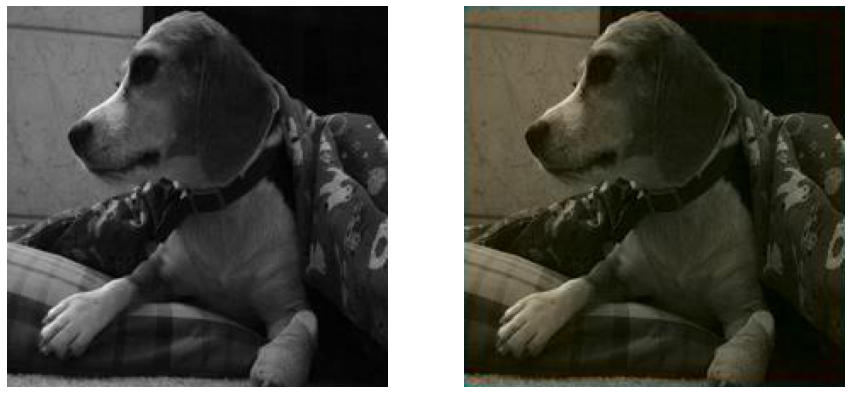

In [ ]:

import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-1-epoch-19.jpg', 'outputs/gray/img-1-epoch-19.jpg'),
               ('outputs/color/img-3-epoch-19.jpg', 'outputs/gray/img-3-epoch-19.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()